<a href="https://colab.research.google.com/github/vipinkailas/TensorFlow/blob/main/Miles_per_gallon_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install seaborn


In [35]:
from __future__ import absolute_import, division,print_function

import pathlib
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.5.0


Get Data 

In [4]:
dataset_path = keras.utils.get_file("auto-mpg.data","http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

Import data using Pandas

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Accelaration','Model year','Origin']
raw_dataset = pd.read_csv(dataset_path,names=column_names,na_values="?",comment='\t',sep=" ",skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Accelaration,Model year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Accelaration    0
Model year      0
Origin          0
dtype: int64

In [7]:
dataset = dataset.dropna()

In [8]:
origin = dataset.pop('Origin')

Convert origin to a one-hot column

In [9]:
dataset['USA'] = (origin == 1)* 1.0
dataset['Europe'] = (origin == 2)* 1.0
dataset['Japan'] = (origin == 3)* 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Accelaration,Model year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Split data into train and test

In [10]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

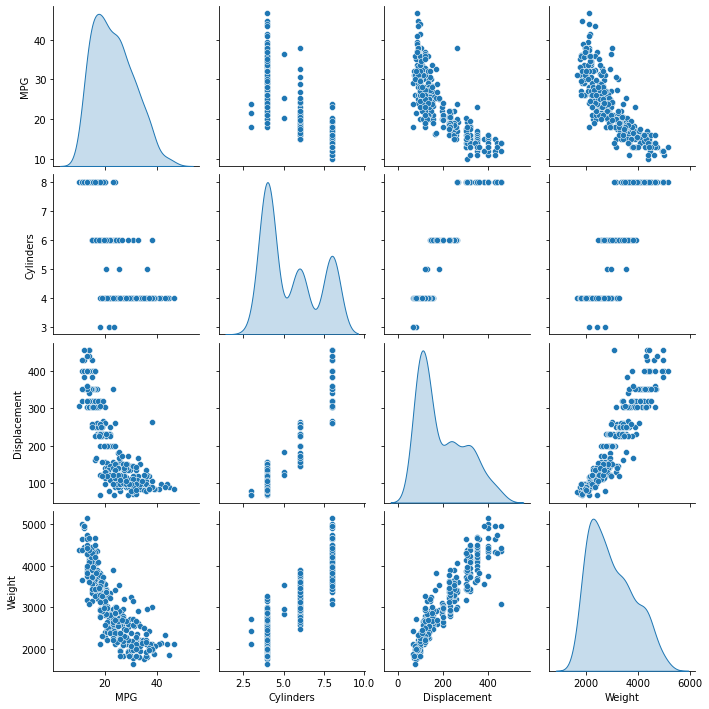

In [11]:
sns.pairplot(train_dataset[["MPG","Cylinders","Displacement","Weight"]],diag_kind="kde")

In [12]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Accelaration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")


Normalize the data

In [17]:
train_dataset.describe().transpose()[['mean','std']]

,mean,std
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Accelaration,15.559236,2.789230
Model year,75.898089,3.675642
USA,0.624204,0.485101
Europe,0.178344,0.383413
Japan,0.197452,0.398712


In [20]:
normalizer = preprocessing.Normalization(axis=-1)


In [23]:
normalizer.adapt(np.array(train_features))

In [24]:
print(normalizer.mean.numpy())

[2.33105106e+01 5.47770691e+00 1.95318497e+02 1.04869446e+02
 2.99025171e+03 1.55592356e+01 7.58980942e+01 6.24203861e-01
 1.78343967e-01 1.97452217e-01]


In [25]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[  28.     4.    90.    75.  2125.    14.5   74.     1.     0.     0. ]]

Normalized: [[ 0.61 -0.87 -1.01 -0.79 -1.03 -0.38 -0.52  0.78 -0.47 -0.5 ]]


Start with a single-variable linear regression, to predict MPG from Horsepower. First create horsepoweer normalizarion layer

In [26]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

Build sequential model

In [27]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Run the untrained model

In [28]:
horsepower_model.predict(horsepower[:10])

array([[ 0.97248673],
       [ 0.5492339 ],
       [-1.7949356 ],
       [ 1.3631817 ],
       [ 1.23295   ],
       [ 0.48411807],
       [ 1.4608554 ],
       [ 1.23295   ],
       [ 0.32132852],
       [ 0.5492339 ]], dtype=float32)

Configure the trainig procedure using compile

In [29]:
horsepower_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error')


Use Model fit to execute training

In [30]:
%%time
history = horsepower_model.fit(train_features['Horsepower'],train_labels,epochs=100,verbose=0,validation_split=0.2)

CPU times: user 3.24 s, sys: 156 ms, total: 3.39 s
Wall time: 5.59 s


In [32]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804664,4.169609,95
96,3.803257,4.176747,96
97,3.802867,4.177386,97
98,3.806780,4.196658,98
99,3.803896,4.194108,99


In [33]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

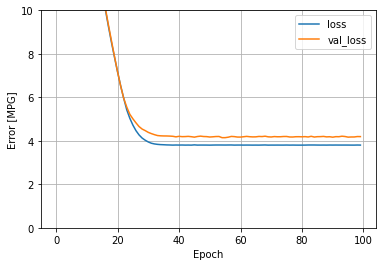

In [36]:
plot_loss(history)

Collect results to test set

In [37]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [38]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

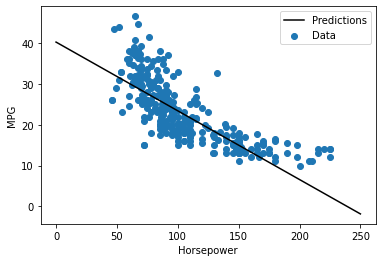

In [39]:
plot_horsepower(x,y)

**Using multiple inpouts**

In [40]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [41]:
linear_model.predict(train_features[:10])

array([[-1.5572131 ],
       [-1.899122  ],
       [ 4.9640527 ],
       [-2.9291923 ],
       [-2.9986877 ],
       [-0.20109889],
       [-3.3555422 ],
       [-4.0750384 ],
       [ 0.4298678 ],
       [-1.7241575 ]], dtype=float32)

In [42]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(10, 1) dtype=float32, numpy=
array([[ 0.15244895],
       [ 0.59952563],
       [ 0.6530048 ],
       [ 0.6734566 ],
       [ 0.639093  ],
       [-0.4645599 ],
       [-0.6503516 ],
       [ 0.1144504 ],
       [-0.42210734],
       [ 0.1632191 ]], dtype=float32)>

In [43]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [44]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 3.52 s, sys: 122 ms, total: 3.64 s
Wall time: 3.39 s


Using all the inputs achieves a much lower training and validation error than the horsepower model:

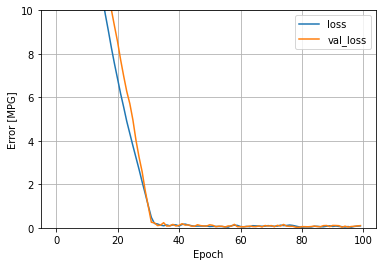

In [45]:
plot_loss(history)

**Deep Neural Network (DNN) regression**
The normalization layer.
Two hidden, nonlinear, Dense layers using the relu nonlinearity.
A linear single-output layer

In [46]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

One variable

In [47]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [48]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model

In [49]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.63 s, sys: 167 ms, total: 3.8 s
Wall time: 5.56 s


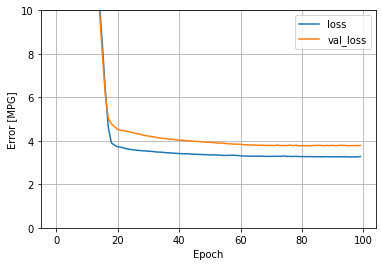

In [50]:
plot_loss(history)

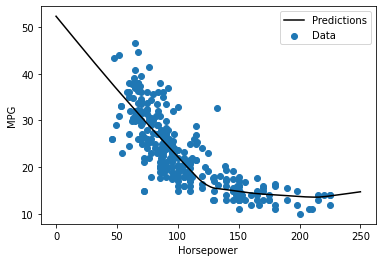

In [51]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plot_horsepower(x, y)

Collect the results in test set

In [52]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

**Full Model**

In [53]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 10)                21        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,950
Trainable params: 4,929
Non-trainable params: 21
_________________________________________________________________


In [54]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.71 s, sys: 174 ms, total: 3.88 s
Wall time: 3.61 s


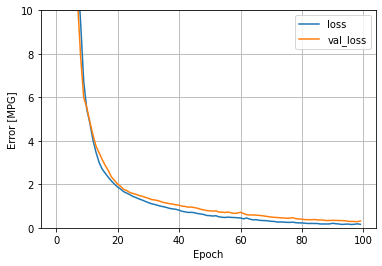

In [55]:
plot_loss(history)

Collect recults 

In [56]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

Check Performance

In [61]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.640983
dnn_horsepower_model,2.895574
dnn_model,0.232846


Make Predictions

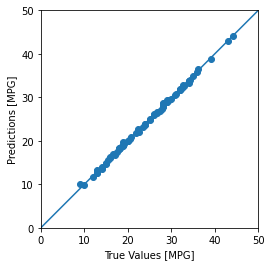

In [62]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Check Error Distribution

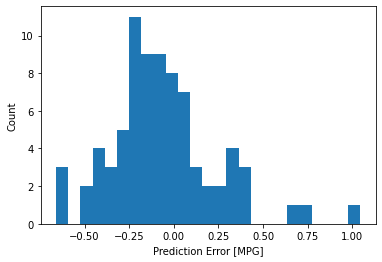

In [63]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

Save Model

In [64]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


Reload model

In [65]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)